# Comparing Branch Stability

This notebook has two purposes. (1) It demonstrates the benefit of detecting branch-based subgroups and (2) it explores how stable 
FLASC's branch detection is under noise and hyper-parameters. 

## Setup
Load libraries used:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from _plotting import *

%matplotlib inline
palette = configure_matplotlib()

from scipy import linalg
from sklearn.utils import shuffle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import pairwise_distances

from flasc import FLASC
from hdbscan import HDBSCAN

## Datasets

For this notebook, we use 2D datasets with a single cluster containing 
three branches arranged in a three-point star. Data points are placed along the 
branches logarithmically, with the densest regions at the center of the cluster.
This construction avoids placing a local density maximum in the branches, 
intentionally making it difficult for HDBSCAN\* to detect them.

In [3]:
def make_dataset(num_samples=100, length=2, scale=0.02):
    """Creates a dataset with three branches.
    
    Datapoints are spaced logarithmically along the branch length,
    with the high-density part at the ends of the branches.
    """
    def rotation(axis = [0, 0, 1], theta = 0):
        return linalg.expm(np.cross(np.eye(3), axis/linalg.norm(axis)*theta))

    def rotate(X, axis = [0, 0, 1], theta = 0):
        M = rotation(axis=axis, theta=theta)
        data = np.hstack((X, np.zeros((X.shape[0], 1), dtype=X.dtype)))
        return (M @ data.T).T[:,:2]
    
    max_exp = np.log(length)
    x = np.exp(np.linspace(0, max_exp, num_samples)) - 1
    branch = np.hstack((x[None].T, np.zeros((x.shape[0], 1), dtype=x.dtype)))
    X = np.vstack((
        rotate(branch, theta=np.pi/2),
        rotate(branch, theta=2 * np.pi / 3 + np.pi / 2),
        rotate(branch, theta=4 * np.pi / 3 + np.pi / 2)
    ))
    X += np.random.normal(scale=scale, size=X.shape)
    y = np.repeat([0, 1, 2], num_samples)
    X, y = shuffle(X, y)
    return X, y

def _centroid(X, y):
    """Computes ground-truth average positions."""
    return np.vstack(
        [ np.average(X[y == i, :], axis=0) for i in range(3) ] + [np.average(X, axis=0)]
    )

The datasets are parameterized by two values: the branch length and noise ratio.
Here, the branch length ($b_l$) controls the difference in density between the
cluster's center and the branches' ends. The noise ratio $n_r$ controls
the standard deviation $\sigma$ of Gaussian noise applied to the data points: 
$$
    n_r = \frac{4 \sigma}{\sqrt{\frac{1}{2}} b_l},
$$
Practically, $\pm 90\%$ of points move less than $n_r b_l$ 
away from their original point after noise is applied. 

Both parameters are varied to explore a wide range of datasets with this 
branching pattern.

In [4]:
# Dataset parameters
lengths = np.unique(np.round(np.exp(np.linspace(np.log(2), np.log(100), 10))))
ratios = (np.exp(np.linspace(0, np.log(2), 10)) - 1)
repeats = np.arange(10)

datasets = pd.DataFrame([
        x for x in itertools.product(
            repeats, 
            ratios,
            lengths, 
        )
    ], columns=[
        'repeat', 'noise_ratio', 'branch_length'
    ]
)
samples = tuple(zip(*[
    make_dataset(
        length=datasets.branch_length[i], 
        scale=(datasets.branch_length[i] * datasets.noise_ratio[i]) / 4 * np.sqrt(1/2)
    )
    for i in range(datasets.shape[0])
]))
datasets['X'] = list(samples[0])
datasets['y'] = list(samples[1])
datasets['centroids'] = [ 
    _centroid(datasets.X[i], datasets.y[i]) for i in range(datasets.shape[0])
]
datasets.branch_length = datasets.branch_length.apply(int)
datasets.to_pickle('./data/generated/branch_stability_data.pickle')

One dataset for each *noise*-*length* combination is shown below, with data points
coloured by their ground-truth branch label. Notice that the clusters' centers
are indeed the densest parts, and that the ground truth labels are mixed in that
region. This will be relevant later on, when we try to evaluate how well FLASC
detects the branches.

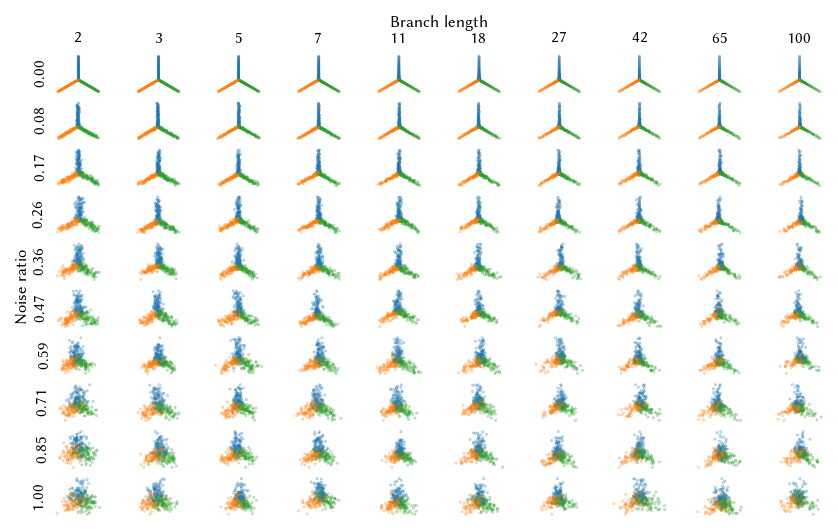

In [5]:
cnt = 1
n_ratios = len(ratios)
n_lengths = len(lengths)
sized_fig(1)
for j, r in enumerate(ratios):
    for i, l in enumerate(lengths):
        plt.subplot(n_ratios, n_lengths, cnt)
        cnt += 1
        
        s =  datasets\
            .query(f'repeat == 4')\
            .query(f'noise_ratio == {r}')\
            .query(f'branch_length == {l}')

        X = s.X.iloc[0]
        y = s.y.iloc[0]
        colors = [palette[l] for l in y]
        plt.scatter(X.T[0], X.T[1], 0.1, colors, alpha=0.5)
        frame_off()
        if i == 0:
            plt.ylabel(f'{r:.2f}', fontsize=8)
        if j == 0:
            plt.title(f'{int(l):d}', fontsize=8)
fig = plt.gcf()
plt.text(0.511, 0.984, 'Branch length', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         transform=fig.transFigure)
plt.text(0.003, 0.465, 'Noise ratio', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90, transform=fig.transFigure)
plt.subplots_adjust(0.03, 0.01, .99, .92)
plt.savefig('./images/branch_stability_ground_truth.png')
plt.show()

## FLASC

First, we analyze FLASC's performance on the datasets. We set several
parameters to fixed values to ensure a single cluster is detected. Unlike 
HDBSCAN\*, FLASC will give all points the 0-label when a single cluster 
is detected.

In [6]:
# Fixed parameters
kwargs = {
    'min_samples': 5,
    'min_cluster_size': 25,
    'allow_single_cluster': True,
}

Other parameters are varied, to analyze FLASC's stability and parameter
sensitivity. We store flasc's final labelling for each combination of 
parameter values.

In [7]:
# Algorithm parameters
min_branch_size = np.arange(2, 25, 2)
branch_selection_method = ['eom', 'leaf']
branch_detection_method = ['full', 'core']
params = pd.DataFrame([
    x for x in itertools.product(
        repeats, ratios, lengths, min_branch_size,
        branch_detection_method, branch_selection_method
    )
], columns=[
    'repeat', 'noise_ratio', 'branch_length', 
    'min_branch_size', 'branch_detection_method',
    'branch_selection_method'
]
)
params['algorithm'] = ['FLASC' for _ in range(params.shape[0])]
params.branch_length = params.branch_length.apply(int)

The cell below actually runs FLASC on the dataset and prepares for
two metrics on the resulting labelling: (1) the adjusted rand index, 
a metric indicating how well FLASC's labelling reflects the ground truth, and
(2) the centroid spread, a metric indicating how varied FLASC's labelling is
across the different samples with the same parameters. Both metrics will be 
explained in more detail below.

Running this cell takes about 20 minutes.

In [8]:
def run_setting(p):
    """Runs flasc on a dataset."""
    # Extract Dataset properties
    subset = datasets[
        (datasets.repeat == p['repeat']) &
        (datasets.noise_ratio == p.noise_ratio) &
        (datasets.branch_length == p.branch_length)
    ].iloc[0]
    X = subset.X
    truth = subset.centroids
    y = subset.y
    
    # Run flasc
    c = FLASC(
        min_branch_size=p.min_branch_size,
        branch_detection_method=p.branch_detection_method, 
        branch_selection_method=p.branch_selection_method,
        **kwargs
    ).fit(X)
    
    # Compute ARI
    ari = adjusted_rand_score(c.labels_, y)

    # Compute centroids
    centroids = []
    num_labels = len(np.unique(c.labels_)) - int(-1 in c.labels_)
    for l in range(num_labels):
        mask = c.labels_ == l
        centroids.append(np.average(X[mask,:], weights=c.probabilities_[mask], axis=0))

    # Assign centroids to ground-truth centroids
    dists = pairwise_distances(centroids, truth)
    order = np.argmin(dists, axis=1)

    # Return everything
    return (
        c.labels_, c.probabilities_, centroids, order, ari, num_labels
    )

(
    params['labels'], 
    params['probabilities'],
    params['centroids'],
    params['true_labels'], 
    params['ari'],
    params['num_labels']
) = zip(*[
    run_setting(params.iloc[i]) for i in trange(params.shape[0])
])
params.to_pickle('./data/generated/branch_stability_labelling_flasc.pickle')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48000/48000 [09:59<00:00, 80.10it/s]


## HDBSCAN\*

Second, we analyze HDBSCAN\* performance on the dataset. The *min_samples* 
parameter is fixed to the same value as used by FLASC

In [9]:
# Fixed parameters
kwargs = {
    'min_samples': int(5),
}

Other parameters are varied to find the best-performing setting, giving HDBSCAN\*
a fair chance to find the branch-subgroups.

In [10]:
# Algorithm parameters
min_cluster_size = np.arange(2, 25, 2)
cluster_selection_method = ['eom', 'leaf']
params = pd.DataFrame([
    x for x in itertools.product(
        repeats, ratios, lengths, min_cluster_size,
        cluster_selection_method,
    )
], columns=[
    'repeat', 'noise_ratio', 'branch_length', 
    'min_cluster_size', 'cluster_selection_method'
])
params['algorithm'] = ['HDBSCAN\*' for _ in range(params.shape[0])]
params.branch_length = params.branch_length.apply(int)

The cell below actually evaluates HDBSCAN\* and computes the adjusted rand index metric in about 10 minutes!

In [11]:
def run_setting(p):
    # Extract dataset
    subset = datasets\
        .query(f'repeat == {p["repeat"]}')\
        .query(f'noise_ratio == {p.noise_ratio}')\
        .query(f'branch_length == {p.branch_length}').iloc[0]
    X = subset.X
    y = subset.y

    # Run HDBSCAN
    c = HDBSCAN(
        min_cluster_size=int(p.min_cluster_size),
        cluster_selection_method=p.cluster_selection_method,
        **kwargs
    ).fit(X)
    
    # Compute ARI
    ari = adjusted_rand_score(c.labels_, y)
    num_labels = len(np.unique(c.labels_)) - int(-1 in c.labels_)
    return (
        c.labels_, c.probabilities_, ari, num_labels
    )

(
    params['labels'], 
    params['probabilities'],
    params['ari'],
    params['num_labels']
) = zip(*[
    run_setting(params.iloc[i]) for i in trange(params.shape[0])
])
params.to_pickle('./data/generated/branch_stability_labelling_hdbscan.pickle')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24000/24000 [03:17<00:00, 121.38it/s]


## Plotting

First, we read in the data files so previous runs can be re-plotted and specify 
human readable names for the columns. Names with an underscore result in an error 
because Latex is used to render text in the images. To disable this, edit
`./notebooks/_plotting.py`!

In [12]:
datasets = pd.read_pickle('./data/generated/branch_stability_data.pickle')
fparams = pd.read_pickle('./data/generated/branch_stability_labelling_flasc.pickle')
hparams = pd.read_pickle('./data/generated/branch_stability_labelling_hdbscan.pickle')
ratios = datasets.noise_ratio.unique()
lengths = datasets.branch_length.unique()

In [13]:
display_names = {
    'columns': {
        'branch_length': 'Branch length',
        'num_clusters': 'Num clusters',
        'num_labels': 'Num labels',
        'num_branches': 'Num branches',
        'noise_ratio': 'Noise ratio',
        'min_branch_size': 'Min branch size',
        'min_cluster_size': 'Min cluster size',
        'branch_detection_method': 'Graph',
        'branch_selection_method': 'Selection',
        'cluster_selection_method': 'Selection',
        'ari': 'ARI',
        'algorithm': 'Algorithm',
        'centroid_spread': 'Centroid spread'
    }
}

### Parameter tuning and sensitivity

First, we try to find out for which parameter settings the algorithms perform
best on this dataset before we compare the algorithms to each other. For this
purpose we use two metrics, the *adjusted rand index* and *centroid spread*.

The *adjusted rand index* (ARI) is a quality measure for clustering algorithms. 
I interpret it as using the clustering as classifier and computing how well data
points of the same class are put into the same cluster. We use this metric
to determine which parameter settings work best.

The *centroid spread* is only used for FLASC. It measures how much the subgroups'
weighted average vary between datasets generated with the same parameters. As such,
it measures how stable FLASC's output is. The spread is expressed in terms
of branch length $b_l$ to be able to compare the different datasets. Specifically.
it is calculated by:
- Computing the ground-truth branch and cluster average (unweighted)
- Computing the FLASC label average (weighted) (= centroid)
- Assigning each FLASC centroid to the closest ground-truth centroid on that dataset.
- Computing the average centroid coordinates (unweighted) for all centroids assigned to the same ground-truth centroid of datasets with the same branch length and noise ratio. (= root)
- Computing the distance of each centroid to their root in terms of branch length $b_l$. The 50 and 95 percentile distance are used to quantify and visualize the centroid spread.

In [ ]:
def _centroid_spread(p):
    # Compute root
    root = [
        np.average(p.centroids[p.true_labels == k, :], axis=0) 
        if np.sum(p.true_labels == k) > 0 else None 
        for k in range(4)
    ]
    # Subtract roots from centroids and scale by branch length
    offsets = np.asarray([root[k] for k in p.true_labels])
    centralized = (p.centroids - offsets) / p.branch_length
    # Compute spread
    spread = pairwise_distances(np.asarray([[0, 0]]), centralized)[0,:]
    return centralized, np.asarray(root), spread

# Merge repeats into single column
grouped = fparams.groupby(by=[
    'branch_length', 'noise_ratio', 'min_branch_size', 
    'branch_detection_method','branch_selection_method'
]).agg(
    centroids=pd.NamedAgg(column="centroids", aggfunc=lambda x: np.concatenate(list(x))),
    true_labels=pd.NamedAgg(column="true_labels", aggfunc=lambda x: np.concatenate(list(x))),
).reset_index()

# Compute roots and spread
(grouped['centralized_centroids'], grouped['roots'], grouped['centroid_spread']) = zip(*[
    _centroid_spread(grouped.iloc[i]) for i in trange(grouped.shape[0])
]) 

The figure below shows one dataset (background points in grey) with its
ground truth centroids (coloured cross) and all FLASC centroids detected on 
datasets with the same noise ratio and branch length (black points). For each
ground-truth centroid, the root is indicated as a coloured pentagon.

The distance between the roots and the centroids is used as *centroid spread*.

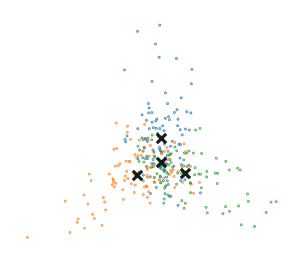

In [15]:
# Pick a dataset setting
r = ratios[-2]
l = lengths[-2]        

# Extract dataset properties
s = datasets\
    .query(f'repeat == 4')\
    .query(f'noise_ratio == {r}')\
    .query(f'branch_length == {l}').iloc[0]
X = s.X
y = s.y
truths = s.centroids

# Extract FLASC properties
s = grouped.query(
    f'noise_ratio == {r} & '
    f'branch_length == {l} & '
    'min_branch_size == 12 &  '
    'branch_detection_method == "core" & '
    'branch_selection_method=="eom"'
).iloc[0]
centroids = s.centroids
labels = s.true_labels
roots = s.roots

# Create figure
sized_fig(1/3, aspect=1)
plt.scatter(X.T[0], X.T[1], 0.1, y, cmap='tab10', vmax=10, label='point')
plt.scatter(truths.T[0], truths.T[1], 20, color='k', marker='x', label='true centriod')
frame_off()
lims = plt.xlim()
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig('./images/branch_stability_true_centroids_1.png')
plt.show()

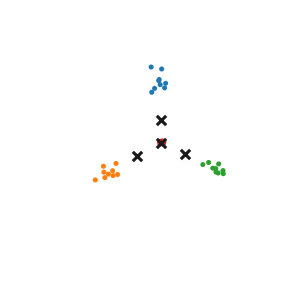

In [16]:
# Create figure
sized_fig(1/3, aspect=1)
plt.scatter(centroids.T[0], centroids.T[1], 2, labels, cmap='tab10', vmax=10, label='found centroid')
plt.scatter(truths.T[0], truths.T[1], 20, color='k', marker='x', label='true centriod')
frame_off()
plt.xlim(lims)
plt.ylim(lims)
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig('./images/branch_stability_found_centroids_all.png')
plt.show()

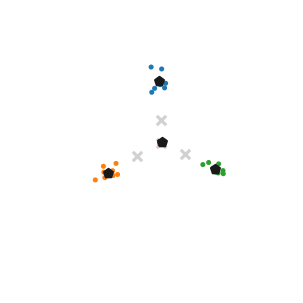

In [17]:
# Create figure
sized_fig(1/3, aspect=1)
plt.scatter(centroids.T[0], centroids.T[1], 2, labels, cmap='tab10', vmax=10, label='found centroid')
plt.scatter(truths.T[0], truths.T[1], 20, color='k', alpha=0.2, marker='x', label='true centriod')
plt.scatter(roots.T[0], roots.T[1], 20, color='k', marker='p', label='root')
# for c, l in zip(centroids, labels):
#     plt.plot([c[0], roots[l, 0]], [c[1], roots[l, 1]], 'k-', linewidth=0.3, zorder=-2)
frame_off()
plt.xlim(lims)
plt.ylim(lims)
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig('./images/branch_stability_found_centroids_root.png')
plt.show()

#### FLASC

In this section, we try to find out for which parameters FLASC performs
best. In addition, we show how sensitive FLASC is to the *min branch size*
parameter.

First, in the figure below, the branch detection and branch selection combinations are
compared by their ARI value over the *min branch size* parameter. The selection
method does not appear to make much difference. The *core* detection method 
performs best on this dataset. This is expected, because the center-subgroup,
detected by FLASC, is smaller in the *core* detection method than in the
*full* detection method. This subgroup is not represented in the ground-truth 
labels, even though semantically it is a useful group, so the smaller that 
group the higher the ARI. At lower *min branch size* values, the ARI value
decreases, probably because too many branches are detected with those settings.

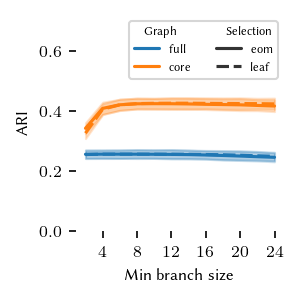

In [18]:
sized_fig(1/3, aspect=1)
sns.lineplot(
    fparams.rename(**display_names), 
    x='Min branch size', y='ARI', hue='Graph', 
    style='Selection', palette='tab10', hue_order=["full", "core"]
)
l = plt.legend(loc='best', ncol=2)
adjust_legend_subtitles(l)
plt.ylim([0, 0.72])
plt.xticks([4, 8, 12, 16, 20, 24])
plt.yticks([0, 0.2, 0.4, 0.6])
plt.ylabel('ARI')
plt.subplots_adjust(0.23, 0.2, 0.99, .99)
plt.show()

Second, in the figure below, the branch detection and branch selection combinations are
compared by their cluster spread value over the *min branch size* parameter. Here,
a lower value is better. Clearly the *full* detection method performs better, it 
has a lower cluster spread and is less sensitive to low *min branch size* values.

For comparing FLASC to HDBSCAN\* we will use the following settings:
- *min branch length* = 12
- *branch detection method* = *core*
- *branch selection method* = *eom*

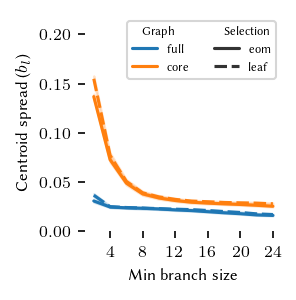

In [19]:
sized_fig(1/3, aspect=1)
sns.lineplot(
    grouped.explode('centroid_spread').rename(**display_names), 
    x='Min branch size', y='Centroid spread', hue='Graph', 
    style='Selection', palette='tab10', hue_order=["full", "core"]
)
l = plt.legend(loc='best', ncol=2)
adjust_legend_subtitles(l)
plt.ylim([0, 0.22])
plt.xticks([4, 8, 12, 16, 20, 24])
plt.ylabel('Centroid spread ($b_l$)')
plt.subplots_adjust(0.27, 0.2, 0.99, .99)
plt.show()

#### HDBSCAN\*
In this section, we try to find out for which parameters HDBSCAN\* performs
best.

In the figure below, HDBSCAN\*'s average ARI value is shown for the different
*cluster selection methods* over the *min cluster size* parameter. Although the
ARI values are low, there is a distinct peak at *min cluster size* = 8 with *cluster selection method* = *eom*

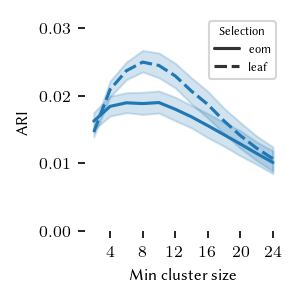

In [20]:
sized_fig(1/3, aspect=1)
sns.lineplot(
    hparams.rename(**display_names), 
    x='Min cluster size', y='ARI', style='Selection',
)
l = plt.legend(title='Selection', loc='best')
adjust_legend_subtitles(l)
plt.ylim([0, 0.032])
plt.xticks([4, 8, 12, 16, 20, 24])
# plt.yticks([0, 0.2, 0.4, 0.6])
plt.ylabel('ARI')
plt.subplots_adjust(0.27, 0.2, 0.99, .99)
plt.show()

### Visualize labeling

In this section we visualize the subgroups found by HDBSCAN\* and FLASC on
one repeat of each *length*-*noise* combination.

First for HDBSCAN\*, because the *leaf* cluster selection method is used, many small
clusters are found and many points are classified as noise. In particular for data
sets with a lower branch length, clusters are found in the branches, providing at
least a hint of their existence.

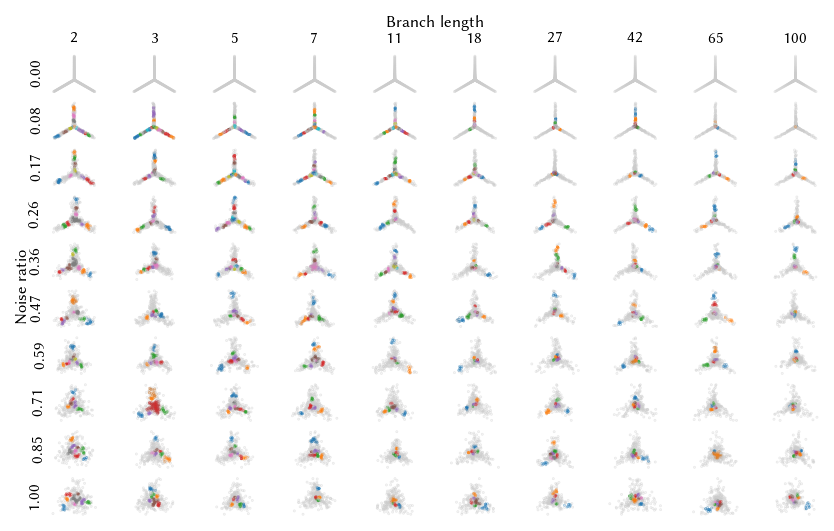

In [21]:
cnt = 1
n_ratios = len(ratios)
n_lengths = len(lengths)
sized_fig(1)
for j, r in enumerate(ratios):
    for i, l in enumerate(lengths):
        plt.subplot(n_ratios, n_lengths, cnt)
        cnt += 1
        
        s =  datasets\
            .query(f'repeat == 4')\
            .query(f'noise_ratio == {r}')\
            .query(f'branch_length == {l}')
        X = s.X.iloc[0]
        y = s.y.iloc[0]
        
        s = hparams\
            .query(f'repeat == 4')\
            .query(f'noise_ratio == {r}')\
            .query(f'branch_length == {l}')\
            .query('cluster_selection_method=="leaf"')\
            .query('min_cluster_size==8')
        labels = s.labels.iloc[0]
        probabilities = s.probabilities.iloc[0]
        colors = [
            (0.8, 0.8, 0.8) if l < 0 else sns.desaturate(palette[l], p) 
            for l, p in zip(labels, probabilities)
        ]
        plt.scatter(X.T[0], X.T[1], 0.1, colors, alpha=0.5)
        frame_off()
        if i == 0:
            plt.ylabel(f'{r:.2f}', fontsize=8)
        if j == 0:
            plt.title(f'{int(l):d}', fontsize=8)
fig = plt.gcf()
plt.text(0.511, 0.984, 'Branch length', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         transform=fig.transFigure)
plt.text(0.008, 0.465, 'Noise ratio', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90, transform=fig.transFigure)
plt.subplots_adjust(0.03, 0.01, .99, .92)
plt.savefig('./images/branch_stability_hdbscan_labels.png')
plt.show()

Now for FLASC; branches are clearly detected as separate entities in addition
to a subgroup the center. We would argue that this segmentation is semantically
most appropriate, even if it is not reflected as strongly in the ground truth 
labels and ARI values.

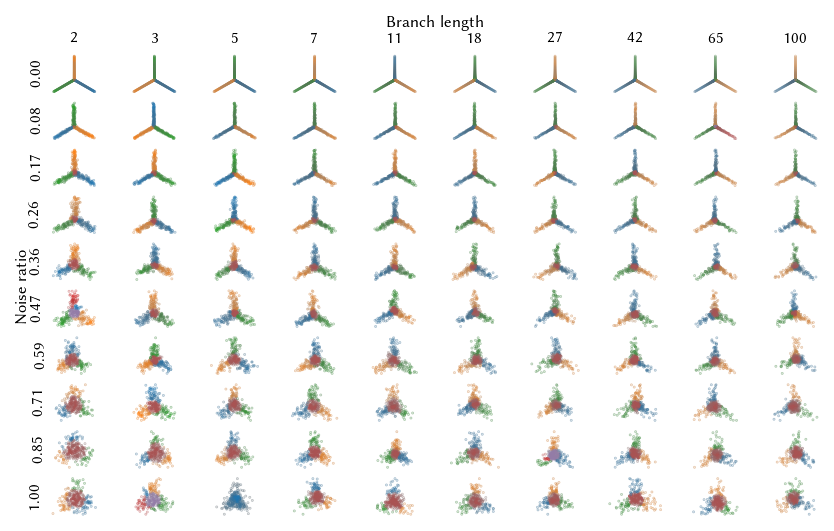

In [22]:
cnt = 1
n_ratios = len(ratios)
n_lengths = len(lengths)
sized_fig(1)
for j, r in enumerate(ratios):
    for i, l in enumerate(lengths):
        plt.subplot(n_ratios, n_lengths, cnt)
        cnt += 1
        
        s =  datasets\
            .query(f'repeat == 4')\
            .query(f'noise_ratio == {r}')\
            .query(f'branch_length == {l}')
        X = s.X.iloc[0]
        y = s.y.iloc[0]
        
        s = fparams\
            .query(f'repeat == 4')\
            .query(f'noise_ratio == {r}')\
            .query(f'branch_length == {l}')\
            .query('branch_detection_method=="core"')\
            .query('branch_selection_method=="eom"')\
            .query('min_branch_size==12')
        labels = s.labels.iloc[0]
        probabilities = s.probabilities.iloc[0]
        colors = [
            (0.8, 0.8, 0.8) if l < 0 else sns.desaturate(palette[l], p) 
            for l, p in zip(labels, probabilities)
        ]
        plt.scatter(X.T[0], X.T[1], 0.1, colors, alpha=0.5)
        frame_off()
        if i == 0:
            plt.ylabel(f'{r:.2f}', fontsize=8)
        if j == 0:
            plt.title(f'{int(l):d}', fontsize=8)
fig = plt.gcf()
plt.text(0.511, 0.984, 'Branch length', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         transform=fig.transFigure)
plt.text(0.008, 0.465, 'Noise ratio', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90, transform=fig.transFigure)
plt.subplots_adjust(0.03, 0.01, .99, .92)
plt.savefig('./images/branch_stability_flasc_labels.png')
plt.show()

### ARI heatmaps

The figures in the previous section can be extended to show the average ARI 
values over all repeats of the same *noise-length* combinations.

In [23]:
def draw_avg_heatmap(data, *args, **kwargs):
    d = data\
        .groupby([args[1], args[0]])[args[2]]\
        .mean()\
        .reset_index()\
        .pivot(index=args[1], columns=args[0], values=args[2])
    return sns.heatmap(d, **kwargs)

In [24]:
# Specify Colormap and ticks
bounds = np.linspace(0, 1, 11)
cmap = mpl.cm.get_cmap('Blues')
norm = BoundaryNorm(bounds, cmap.N)
yticks = [0.5, 3.5, 6.5, 9.5]
ytick_labels = [ f"{ratios[int(r)]:.2f}" for r in yticks ]
xticks = [0.5, 3.5, 6.5, 9.5]
xtick_labels = [ f"{int(lengths[int(r)]):d}" for r in xticks ]

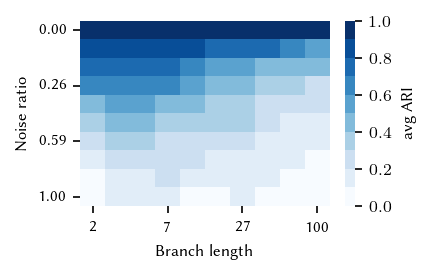

In [25]:
sized_fig(1/2)

fset = fparams\
    .query('min_branch_size == 12 & branch_selection_method=="eom" & branch_detection_method=="core"')\
    [['repeat','noise_ratio', 'branch_length', 'algorithm', 'ari']]
draw_avg_heatmap(
    fset.rename(**display_names),
    'Branch length', 'Noise ratio', 'ARI',
    cmap=cmap, norm=norm, cbar_kws={'label': 'avg ARI'}
)

# Update ticks
plt.yticks(yticks)
plt.xticks(xticks)
plt.gca().set_yticklabels(ytick_labels)
plt.gca().set_xticklabels(xtick_labels)

# Adjust spacing and save
plt.subplots_adjust(0.17, 0.22, 0.93, 0.95, wspace=0)
plt.savefig('./images/branch_stability_flasc_heatmap_avg_ari.png', dpi=300)
plt.show()

The heatmap indicates how well FLASC behaves over different 
noise and branch lengths. As expected, the more noise the lower the ARI value.
This pattern appears to be stronger for larger *branch lengths*, perhaps because
FLASC is more likely to find false-positive branches in those scenarios.

### Branch stability

An important aspect of a clustering algorithm is the stability. It should not 
only accurately describe the underlying data's structure, it should also give 
similar outputs on similar data set. In this section, we try to compare and 
visualize this stability using the centroid spread.

The first figure shows the centroids of all detected subgroups relative to their
root point. The crosshairs indicate $1/4$ branch-length in each direction:

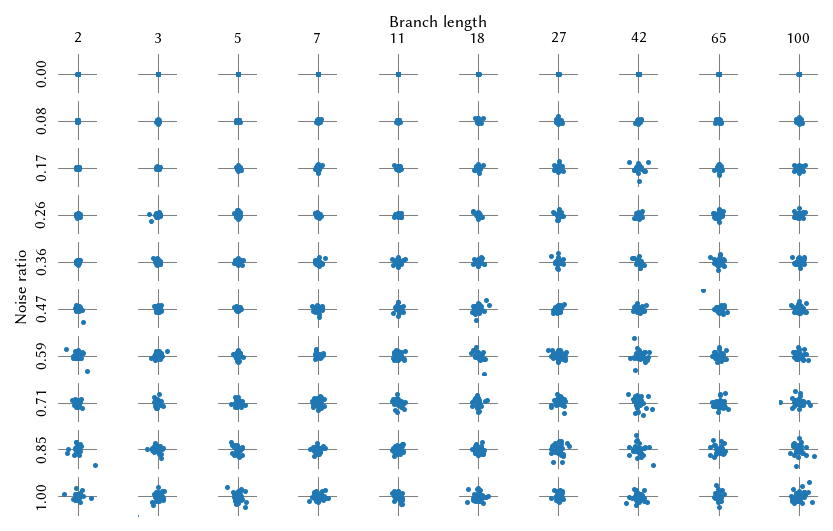

In [26]:
cnt = 1
n_ratios = len(ratios)
n_lengths = len(lengths)
cmap = mpl.cm.get_cmap('Blues')
norm = BoundaryNorm([0, 25, 50, 75, 95, 100], cmap.N)
sized_fig(1)
for j, r in enumerate(ratios):
    for i, l in enumerate(lengths):
        plt.subplot(n_ratios, n_lengths, cnt)
        cnt += 1
        
        s = grouped.query(
            f'noise_ratio == {r} & branch_length == {l} & '
            'min_branch_size == 12 & branch_detection_method=="core" & '
            'branch_selection_method=="eom"')
        centralized = s.centralized_centroids.iloc[0]
        if (s.shape[0]):
            plt.plot([-0.25, 0.25], [0, 0], color=(0.5, 0.5, 0.5), linewidth=0.5, zorder=-1)
            plt.plot([0, 0], [-0.25, 0.25], color=(0.5, 0.5, 0.5), linewidth=0.5, zorder=-1)
            plt.scatter(centralized.T[0], centralized.T[1], 2, color=palette[0], zorder=2)
            plt.xlim([-0.25, 0.25])
            plt.ylim([-0.25, 0.25])

        frame_off()
        plt.gca().set_aspect(1)
        if i == 0:
            plt.ylabel(f'{r:.2f}', fontsize=8)
        if j == 0:
            plt.title(f'{int(l):d}', fontsize=8)

fig = plt.gcf()
plt.text(0.511, 0.984, 'Branch length', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         transform=fig.transFigure)
plt.text(0.004, 0.465, 'Noise ratio', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90, transform=fig.transFigure)
plt.subplots_adjust(0.03, 0.01, .99, .92)
plt.show()

It is slightly easier to interpret the result when the spreads are quantified by
the $50$ and $95$ percentile distances to $(0, 0)$, which can be visualized as
circles:

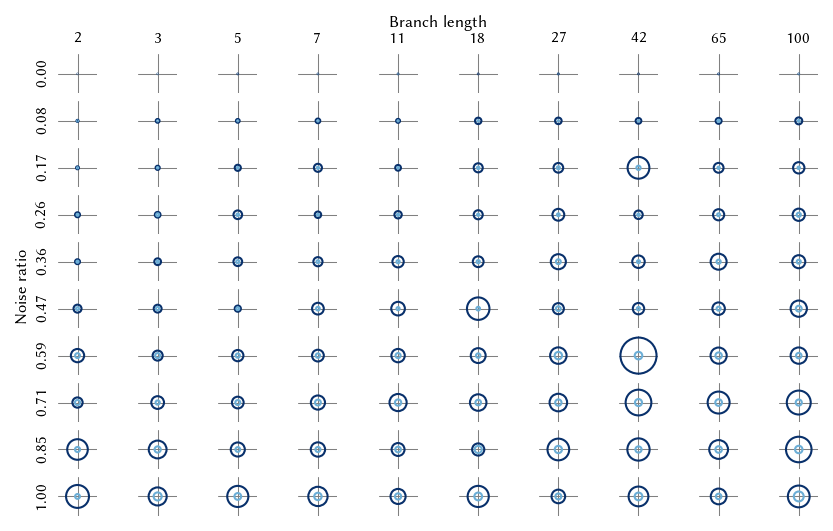

In [27]:
cnt = 1
n_ratios = len(ratios)
n_lengths = len(lengths)
cmap = mpl.cm.get_cmap('Blues')
norm = BoundaryNorm([0, 25, 50, 75, 95, 100], cmap.N)
sized_fig(1)
for j, r in enumerate(ratios):
    for i, l in enumerate(lengths):
        plt.subplot(n_ratios, n_lengths, cnt)
        cnt += 1
        
        s = grouped.query(
            f'noise_ratio == {r} & '
            f'branch_length == {l} & '
            'min_branch_size == 12 & '
            'branch_detection_method=="core" & '
            'branch_selection_method=="eom"'
        )
        if (s.shape[0]):
            distances = s.centroid_spread.iloc[0]
            plt.plot([-0.25, 0.25], [0, 0], color=(0.5, 0.5, 0.5), linewidth=0.5, zorder=-1)
            plt.plot([0, 0], [-0.25, 0.25], color=(0.5, 0.5, 0.5), linewidth=0.5, zorder=-1)
            for p in [95, 50]:
                circle = plt.Circle((0, 0), 
                                    radius=np.percentile(distances, p), 
                                    fill=False, color=cmap(norm(p)), linewidth=1)
                plt.gca().add_patch(circle)
            plt.xlim([-0.25, 0.25])
            plt.ylim([-0.25, 0.25])

        frame_off()
        plt.gca().set_aspect(1)
        if i == 0:
            plt.ylabel(f'{r:.2f}', fontsize=8)
        if j == 0:
            plt.title(f'{int(l):d}', fontsize=8)

fig = plt.gcf()
plt.text(0.511, 0.984, 'Branch length', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         transform=fig.transFigure)
plt.text(0.004, 0.465, 'Noise ratio', 
         fontsize=8,
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90, transform=fig.transFigure)
plt.subplots_adjust(0.03, 0.01, .99, .92)
plt.show()

The overall pattern is similar to the ARI heatmaps. The spread increases with noise
and that effect is stronger for larger branch lengths. This figure can also be 
shown as a heatmap like with the ARI values:

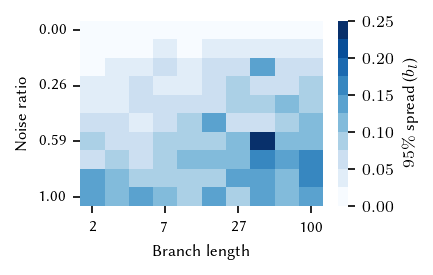

In [28]:
# Specify Colormap and ticks
bounds = np.linspace(0, 1/4, 11)
cmap = mpl.cm.get_cmap('Blues')
norm = BoundaryNorm(bounds, cmap.N)
yticks = [0.5, 3.5, 6.5, 9.5]
ytick_labels = [ f"{ratios[int(r)]:.2f}" for r in yticks ]
xticks = [0.5, 3.5, 6.5, 9.5]
xtick_labels = [ f"{int(lengths[int(r)]):d}" for r in xticks ]

# Draw heatmaps side by side
sns.heatmap(
    grouped
        .query(
            'min_branch_size == 12 & '
            'branch_detection_method=="core" & '
            'branch_selection_method=="eom"'
        )\
        .groupby(['branch_length', 'noise_ratio']) \
        .agg(centroid_spread=pd.NamedAgg(
            column="centroid_spread", 
            aggfunc=lambda x: np.percentile(x.iloc[0], 95)
        )) \
        .reset_index() \
        .rename(**display_names)\
        .pivot(index='Noise ratio', columns='Branch length', values='Centroid spread'),
    cmap=cmap, 
    norm=norm, 
    cbar_kws={'label': '$95\%$ spread ($b_l$)'}
)

# Update size
size_fig(1/2)

# Update ticks and colorbars 
ax = plt.gca()
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Adjust spacing and save
plt.subplots_adjust(0.17, 0.22, 0.91, 0.95, wspace=0)
plt.savefig('./images/branch_stability_flasc_heatmap_95_spread.png', dpi=300)
plt.show()